In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

# fix random seed
torch.manual_seed(0)

from decoupled_linear import DecoupledLinear
from utils import extract_transformers

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

## Create Miscalibrated Model and Example Data

In [2]:
# create base model
base_model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    ).double()
base_model.requires_grad_(False)
base_model.to(device)

# create example data
x = torch.rand((100, 5), dtype=torch.double)
pred = base_model(x)

In [3]:
# create miscalibrated model
x_size, y_size = x.shape[1], pred.shape[1]
miscal_scale = 0.3
y_mask = [True, False]  # selects which parts of the output parameters are used
miscal_model = DecoupledLinear(
    model=base_model,
    x_size=x_size,
    y_size=y_size,
    x_offset_initial=miscal_scale * torch.rand(x_size),
    x_scale_initial=torch.ones(x_size) + miscal_scale * torch.rand(x_size),
    y_offset_initial=miscal_scale * torch.rand(y_size),
    y_scale_initial=torch.ones(y_size) + miscal_scale * torch.rand(y_size),
    y_mask=y_mask,
)
miscal_model.requires_grad_(False)
miscal_model.to(device)

DecoupledLinear(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
  (x_offset_prior): NormalPrior()
  (x_scale_prior): GammaPrior()
  (raw_x_scale_constraint): Positive()
  (y_offset_prior): NormalPrior()
  (y_scale_prior): GammaPrior()
  (raw_y_scale_constraint): Positive()
)

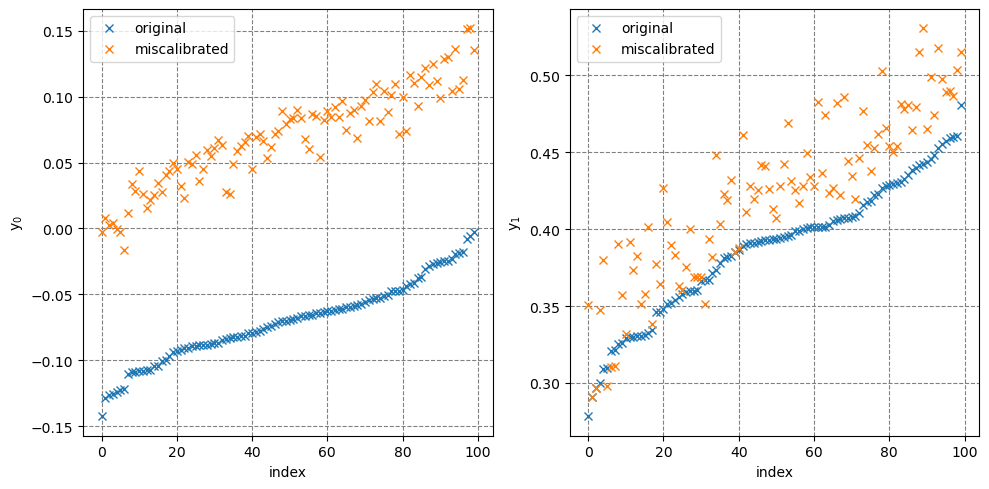

In [4]:
# miscalibrated predictions
miscal_pred = miscal_model(x)
fig, ax = plt.subplots(nrows=1, ncols=y_size, figsize=(5 * y_size, 5))
for i in range(y_size):
    idx_sort = torch.argsort(pred[:, i])
    ax[i].plot(pred[idx_sort, i].cpu(), "C0x", label="original")
    ax[i].plot(miscal_pred[idx_sort, i].cpu(), "C1x", label="miscalibrated")
    ax[i].grid(color="gray", linestyle="dashed")
    ax[i].set_xlabel("index")
    ax[i].set_ylabel(f"y$_{i}$")
    ax[i].legend(loc="upper left")
fig.tight_layout()

## Create and Train Calibrated Model

In [5]:
# create calibrated model
cal_model = DecoupledLinear(
    model=miscal_model,
    x_size=x_size,
    y_size=y_size,
    y_mask=y_mask,
)
cal_model.to(device)

In [6]:
# define trainable parameters
trainable_params = cal_model.raw_calibration_parameters
trainable_params

[Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True)]

In [7]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y


# define dataloader
trainloader = torch.utils.data.DataLoader(
    dataset=Dataset(x, pred),
    batch_size=pred.shape[0],
    shuffle=True,
    num_workers=0,
    pin_memory= not device =='cuda',  # we can't use this if we're on the GPU
)

# define optimizer and loss function
optimizer = torch.optim.Adam(
    params=trainable_params,
    lr=1e-3,
    weight_decay=1e-3,  # regularization favors conservative calibration
)
criterion = nn.L1Loss()

In [8]:
%%time
# training loop
losses = []
n_epochs = int(1e4)
for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
        inputs, targets = batch_data
        optimizer.zero_grad()
        outputs = cal_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i == 0:
            losses.append(loss.item())

CPU times: user 5.95 s, sys: 33.4 ms, total: 5.99 s
Wall time: 5.99 s


## Training Results

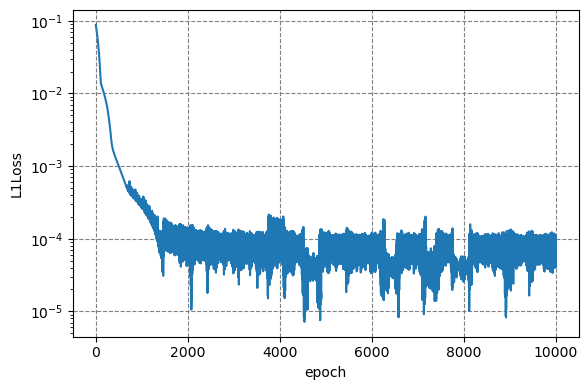

In [9]:
# plot training process
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel("epoch")
ax.plot(losses, "C0")
ax.set_ylabel(criterion.__class__.__name__)
ax.grid(color="gray", linestyle="dashed")
ax.set_yscale("log")
fig.tight_layout()

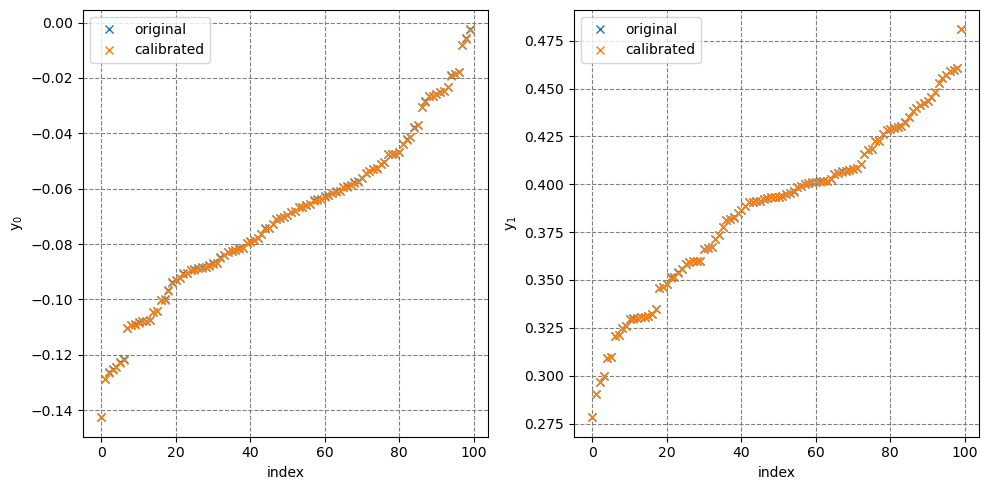

In [10]:
# calibrated predictions
with torch.no_grad():
    cal_pred = cal_model(x)
fig, ax = plt.subplots(nrows=1, ncols=y_size, figsize=(5 * y_size, 5))
for i in range(y_size):
    idx_sort = torch.argsort(pred[:, i])
    ax[i].plot(pred[idx_sort, i].cpu(), "C0x", label="original")
    ax[i].plot(cal_pred[idx_sort, i].cpu(), "C1x", label="calibrated")
    ax[i].grid(color="gray", linestyle="dashed")
    ax[i].set_xlabel("index")
    ax[i].set_ylabel(f"y$_{i}$")
    ax[i].legend(loc="upper left")
fig.tight_layout()

In [11]:
# calibration parameters
df_x = pd.DataFrame(columns=[["x_offset"] * 2 + ["x_scale"] * 2, ["target", "learned"] * 2])
df_y = pd.DataFrame(columns=[["y_offset"] * 2 + ["y_scale"] * 2, ["target", "learned"] * 2])
for df in [df_x, df_y]:
    for col in df.columns:
        model = miscal_model
        if col[-1] == "learned":
            model = cal_model
        values = getattr(model, col[0])
        if col[-1] == "learned":
            if "offset" in col[0]:
                values = -values
            elif "scale" in col[0]:
                values = 1.0 / values
        df.loc[:, col] = values.detach().cpu().tolist()
pd.set_option("display.float_format", "{:.4f}".format)

In [12]:
df_x

x_offset         x_scale        
    target learned  target learned
0   0.2047  0.2323  1.1372  1.1370
1   0.1332  0.1518  1.1408  1.1406
2   0.2101  0.2221  1.0559  1.0558
3   0.2559  0.2809  1.0957  1.0958
4   0.2152  0.2674  1.2475  1.2470

In [13]:
df_y

y_offset         y_scale        
    target learned  target learned
0   0.0899  0.0981  1.0905  1.0896
1   0.0000 -0.0000  1.0000  1.0000

## Use Transformers to Build Calibrated Model

In [14]:
# extract transformers from calibrated model
input_transformer, output_transformer = extract_transformers(cal_model)


# define transformed model
class TransformedModel(nn.Module):
    def __init__(self, model, input_transformer, output_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def forward(self, x):
        x = self.input_transformer(x)
        x = self.model(x)
        x = self.output_transformer.untransform(x)
        return x


# create transformed model
transformed_model = TransformedModel(miscal_model, input_transformer, output_transformer)

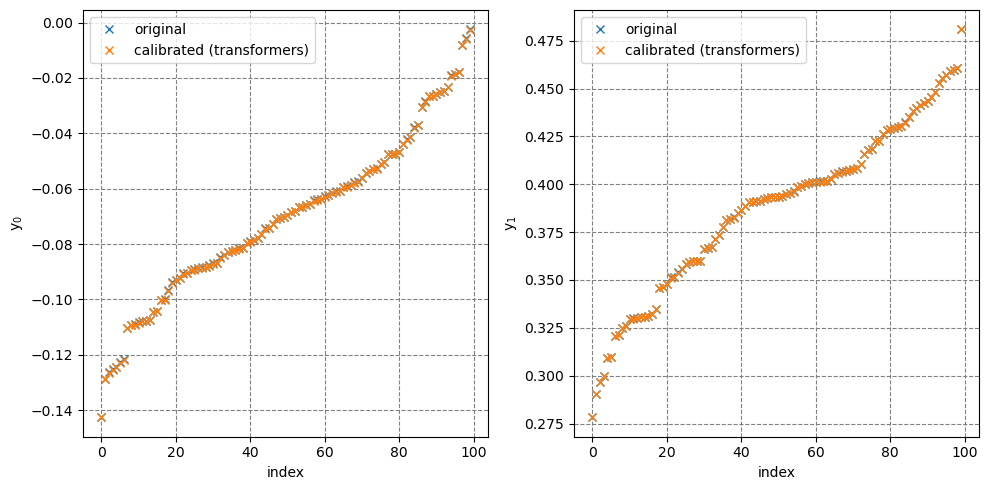

In [15]:
# predictions with transformed model
with torch.no_grad():
    transformed_pred = transformed_model(x)
fig, ax = plt.subplots(nrows=1, ncols=y_size, figsize=(5 * y_size, 5))
for i in range(y_size):
    idx_sort = torch.argsort(pred[:, i])
    ax[i].plot(pred[idx_sort, i].cpu(), "C0x", label="original")
    ax[i].plot(transformed_pred[idx_sort, i].cpu(), "C1x", label="calibrated (transformers)")
    ax[i].grid(color="gray", linestyle="dashed")
    ax[i].set_xlabel("index")
    ax[i].set_ylabel(f"y$_{i}$")
    ax[i].legend(loc="upper left")
fig.tight_layout()